## IEC 판정기준

<div style="text-align: right"> 작성자 : 유광명</div>  

<div style="text-align: right"> 1차 수정일: 2020.05.12 </div> 
<div style="text-align: right"> 최종 수정일: 2023.02.01 </div> 

In [1]:
from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 60
# display low 수를 늘리기 위해스는 원본데이터 row 길이 보다 커야 함

In [2]:
# 상단 코드가 에러시(폰트 이름 달라서 발생)
mpl.rcParams['axes.unicode_minus'] = False
_path = "c:\Windows\Fonts\KoPubWorld Dotum Bold.ttf"
_font_name = font_manager.FontProperties(fname=_path).get_name()
rc('font', family=_font_name)
mpl.rcParams['axes.unicode_minus']=False # 마이너스 폰트 깨짐방지

In [3]:
import gc
gc.enable()

## 1. 데이터 로딩 및 기본정보 확인

### 1.1 데이터 로딩

In [4]:
df = pd.read_pickle('data/DGA_rev_data(DB_for_IEC).pickle')

In [5]:
df.head()

,office1,office2,name,maker,volt,mfg_year,sample_date,operation,anal_type,H2,C2H2,C2H4,CH4,C2H6,C3H8,r1(KEPCO),CO,CO2,r2(KEPCO),etc,S/S,eq_type,eq_num,eq_phase,volt_by_name,sample_year,sample_month,sample_season,age(year),age(month),long_term,TCG1,TCG2,TG,%H2,%C2H2,%C2H4,%CH4,%C2H6,%CO,CH4/H2,C2H2/C2H4,C2H2/CH4,C2H6/C2H2,C2H4/C2H6,gas_ratio_p,dH2,dC2H2,dC2H4,dC2H6,dC3H8,dCO,dCO2,dTCG1,dTCG2,dTG,sample_cnt,r(keygas),r(doernburg),r(rogers)
0,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,효성,154,1998,1998-06-20,신설,NaN,0.0,0.0,0.0,7.0,0.0,0.0,정상,23.0,84.0,정상,NaN,신서귀S/S,M.Tr,#1,A,154,1998,6,1,0,5,0,7.0,7.0,114.0,0.000,0.0,0.0,0.2333,0.0,0.7667,1.4,1.0,0.14286,1.0,1.0,1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,normal,normal,N.A.
1,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,효성,154,1998,1998-11-26,신설,NaN,10.0,0.0,0.0,1.0,0.0,0.0,정상,87.0,1738.0,정상,NaN,신서귀S/S,M.Tr,#1,A,154,1998,11,2,0,10,0,11.0,11.0,1836.0,0.102,0.0,0.0,0.0102,0.0,0.8878,0.1,1.0,1.00000,1.0,1.0,1,1.666667,0.0,0.0,0.0,0.0,10.666667,275.666667,0.666667,0.666667,287.000000,2,normal,normal,N.A.
2,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,효성,154,1998,1999-12-07,신설,NaN,0.0,0.0,0.0,3.0,0.0,0.0,정상,108.0,1110.0,정상,NaN,신서귀S/S,M.Tr,#1,A,154,1999,12,3,1,23,0,3.0,3.0,1221.0,0.000,0.0,0.0,0.0270,0.0,0.9730,0.6,1.0,0.33333,1.0,1.0,1,-0.714286,0.0,0.0,0.0,0.0,1.500000,-44.857143,-0.571429,-0.571429,-43.928571,3,normal,normal,N.A.
3,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,효성,154,1998,2000-11-29,신설,NaN,0.0,0.0,0.0,2.0,0.0,0.0,정상,203.0,679.0,정상,NaN,신서귀S/S,M.Tr,#1,A,154,2000,11,2,2,34,0,2.0,2.0,884.0,0.000,0.0,0.0,0.0098,0.0,0.9902,0.4,1.0,0.50000,1.0,1.0,1,0.000000,0.0,0.0,0.0,0.0,7.916667,-35.916667,-0.083333,-0.083333,-28.083333,4,normal,normal,N.A.
4,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,효성,154,1998,2001-12-10,운전중,NaN,0.0,0.0,0.0,0.0,0.0,0.0,정상,222.0,537.0,정상,NaN,신서귀S/S,M.Tr,#1,A,154,2001,12,3,3,47,0,0.0,0.0,759.0,0.000,0.0,0.0,0.0000,0.0,1.0000,0.2,1.0,1.00000,1.0,1.0,0,0.000000,0.0,0.0,0.0,0.0,1.357143,-10.142857,-0.142857,-0.142857,-8.928571,5,normal,normal,N.A.


In [6]:
df.columns

Index(['office1', 'office2', 'name', 'maker', 'volt', 'mfg_year',
       'sample_date', 'operation', 'anal_type', 'H2', 'C2H2', 'C2H4', 'CH4',
       'C2H6', 'C3H8', 'r1(KEPCO)', 'CO', 'CO2', 'r2(KEPCO)', 'etc', 'S/S',
       'eq_type', 'eq_num', 'eq_phase', 'volt_by_name', 'sample_year',
       'sample_month', 'sample_season', 'age(year)', 'age(month)', 'long_term',
       'TCG1', 'TCG2', 'TG', '%H2', '%C2H2', '%C2H4', '%CH4', '%C2H6', '%CO',
       'CH4/H2', 'C2H2/C2H4', 'C2H2/CH4', 'C2H6/C2H2', 'C2H4/C2H6',
       'gas_ratio_p', 'dH2', 'dC2H2', 'dC2H4', 'dC2H6', 'dC3H8', 'dCO', 'dCO2',
       'dTCG1', 'dTCG2', 'dTG', 'sample_cnt', 'r(keygas)', 'r(doernburg)',
       'r(rogers)'],
      dtype='object')

In [7]:
data = df[['office1', 'office2',
           'H2', 'C2H2', 'C2H4', 'CH4','C2H6', 'C3H8', 'CO', 'CO2',
           'TCG1', 'TCG2', 'TG',
           'C2H2/C2H4', 'CH4/H2', 'C2H4/C2H6','gas_ratio_p',
           'S/S','eq_type', 'eq_num', 'eq_phase', 'volt_by_name', 
           'sample_year','sample_month',
           'age(year)', 'age(month)']]

In [8]:
data.shape

(135941, 26)

## 2. IEC 기준 

### 2.1 고장의 종류  
(IEC 60599 3.1.7~9, 5.2 )

- **PD :** cold plasma(corona), 절연지의 X-wax, sparking, 작은구멍, 탄화흔적  
- **D1(Discharge of Low Energy) :** 큰 절연지 탄화흔적(구멍), 절연유 탄소입자  
- **D2(Discharge of High Energy)** : 절연지의 광범위한 손상 및 탄화흔적, 금속 용융, 광범위한 절연지 탄화, 가끔 대전류가 흘러서 설비가 비상정지(trip) 되는 경우도 있음  
- **T1(thermal fault1) :** < 300'C, 갈색 절연지  
- **T2 :** 300'C < t < 700'C, 절연지 또는 절연유 탄화흔적  
- **T3 :** 절연유의 확실한 탄화흔적(t > 700'C), 절연유의 확연한 탄화흔적(t > 800'C), 금속용융(t > 1000'C)

<img src = 'pic/2.12.1.jpg' width = 300>

### 2.2 Basic Gas Ratios : C2H2/C2H4, CH4/H2, C2H4/C2H6  
(IEC 60599 5.4)

<img src = 'pic/2.12.2.jpg' width = 400>

- 어떤 지역에서는 CH4/H2 대신 C2H2/C2H6이 사용되기도 하며, 약간의 다른 ratio 값이 사용되기도 한다.  
- 위 기준은 적어도 한개의 가스 측정 값이나 Rate가 정상범위를 초과했을 때 적용된다.  (확인요, clause 9)  
- PD는 instrument tr에 대해 CH4/H2 < 0.2가, 부싱에 대해 CH4/H2<0.07가 적용된다.  
- NS : Non-significant whatever the values  
- 위 결과는 power transformer, instrument transformer 등을 포함하는 일반적인 결과임(특정 설비에 대해서는 값이 변경될 수도 있음)

- 3가지 faults로 구분된 다음의 간소화된 모델이 사용되기도 한다.

<img src = 'pic/2.12.3.jpg' width = 300>

### 2.3 Additional Gas Ratios : CO2/CO, O2/N2, C2H2/H2  
(IEC 60599 5.4 ~ 7)  

- CO2/CO : 이 두 값은 온도 증가에 따라 급격하게 발생한다. CO2/CO < 3는 탄화를 동반하는 절연지 부분의 fault로 간주된다.(단, 별도의 correction 과정이 필요하므로 본 데이터에서 적용가능한지 검토 필요)  
- O2/N2 : 이 두 가스는 절연유에서 검출됨. 정상상태에서 O2/N2는 0.5 부근임. 절연유 산화와 절연지 노화로 O2 소모가 늘어나게 됨.(즉 수명지표로 활용가능) 그러나 O2/N2 < 0.3 이면 fault로 간주할 수 있음  
- C2H2/H2 : TR의 OLTC의 동작에 의해 D1에 해당하는 가스를 방출할 수가 있음. 따라서 fault가 아닌데 fault로 간주될 수도 있음. 특히 C2H2/H2 > 2~3 은 OLTC 고장을 나타내는 것임. --->(활용불가)  

### 2.4 Condition for Calculating Ratios  
(IEC 60599 6)  
- 가스 측정 값이 0이거나 S보다 작은 값이면 ratio 계산시 S를 사용한다.  
- 이 방법은 적어도 한개의 가스가 typical value를 초과했을때만 적용한다.
- typical range는 운영자가 정한다.(ex 90%, 95%)
- If gas ratios are different from those for the previous analysis, a new fault may superimpose tself on an old one or normal ageing. In order to get only the gas ratios corresponding to the new fault, subtract the previous DGA values from the last ones and recalculate ratios. This is particularly true in the case of CO and CO2 (see 5.4). Be sure to compare DGA values of samples taken at the same place and preferably in moving oil. Interpretation should also take into account treatments previously made on the equipment, such as repair, oil degassing or filtering, which may affect the level of gases in the oil.

<img src = 'pic/2.12.4.jpg' width = 600>

### 2.5 Uncertainty on Gas Ratios  
(IEC 60599 6.2)  
- 측정 값의 정확도 문제로 인해 ratio도 불확실 성이 있을수도 있다. 측정값이 10xS 정도는 되어야 가스 측정 정밀도가 5%가 되고, 그렇게 되면 ratio 정밀도가 10%가 된다. 10xS 이하의 양에서는 정밀도가 급격히 떨어진다.**(코드에 반영)**  
- 따라서 측정크기가 10xS 아래 일때는 정밀도와 variation을 유념해야 한다.

### 2.6 Probability of failure in service  
(IEC 60599 8.1)  
- typical values, nominal values 아래의 값은 고장 확률이 낮다.  
- 고장확률은 측정 값이 그 이상일 때 높아진다. 
- 실제 고장이 높더라도 그 값이 높으면 확률은 높다.
- 고장의 종류는 단기에 발생하는 것과 장시간에 걸쳐 서서히 나빠지는 두가지가 있다.
- 단기성은 on-line detector로 검출하고, 장기성은 lab기반 dga로 검출한다.

### 2.7 Typical concentration values  
(IEC 60599 8.2)  
- 정상 값은 고장이 발생하지 않는 설비에서 측정한 값들 중에서 빈번하게 나타나는 범위를 뜻한다.(예를 들어 90% 범위, 일반적으로 90%를 사용한다., 해볼것)
- 이 값은 진단의 iniitial value 정도로 사용해야지 진단 기준으로 사용해서는 안된다.  
- 일반적으로 정상범위는 커미셔닝 후 운전시간, 설비 타입, 등과 같은 것에 영향을 받는다. 특히 power tr의 경우 부하, 운영모드 등에도 영향을 받는다.  
- 정상 값 계산 중 가장 간단한 방법은 설비별로 DGA 값을 모으는 것이다.  
the cumulative number of DGA analyses where the gas concentration is below a given value is calculated, then plotted as a function of gas concentration. Using the plotted curve, the gas concentration corresponding to a given percentage of the total cumulative number of analyses (for instance 90 %)
is the 90 % typical concentration value for that gas and type of equipment.  
- 선정한 정상 범위가 지나치게 낮으면 이상 진단 알람이 다수 발생하게 되어 신뢰성이 떨어진다. 지나치게 높으면 알람에 앞서서 고장이 발생할 수도 있다.  
- 일반적으로 instrument tr이나 부싱의 정상범위는 낮게, Power TR의 정상범위는 높게 설정한다.(p18)

### 2.8 Rates of gas increase  
(IEC 60599 8.3)  
- 측정 가스 증가 추세가 없으면 고장이 사라졌다는 의미이다.  
- 이 때 고려되어야 할 부분은 설비종류, age, 고장유형, 부해패턴 등이다. 이를 고려하여 기준 증가율을 정해야 한다.  
- 개월당 10% 이상 증가한 경우 고장의 전조 증상으로 본다.(단 측정 값의 정밀도가 보장되어야 한다. 10% 이상 정밀도, S 값 확인 필요)  
- 주당 50% 이상 증가하는 것은 심각한 고장이나 높은 에너지로 이한 고장이 발생했음을 나타낸다.(D2, T3)  
- CO, CO2의 경우 증가율의 oil-paper 비율에 의존적이어서 타입에 따라 다르게 나타날 수도 있다.  
- onlie gas detector의 경우 ... **특허(online + offline)**
- On-line gas detectors, including those already available for hydrogen, may be particularly wellsuited for detecting non-typical rates of gas increase occurring within minutes, hours or weeks, which is generally not possible with routine oil samplings done at monthly or yearly intervals. However, when such increases are detected by a gas detector, complete DGA analyses shall be made at the laboratory to confirm the detector readings, evaluate the rates of increase of the various gases and identify the fault.

### 2.9 Recommended method of DGA interpretation  
(IEC 60599 9)

<img src = 'pic/2.12.5.jpg' width = 700>

- a) 측정 값이 analytical detection limit(IEC 6.1 참고) 범주에 있는지 확인한다. 그리고 precision을 체크한다. 모든 측정 값과 rate가 정상범위 안에 있을 때는 '정상'으로 판별한다. 최소 한개 가스 이상이 측정 값이나 증가율 범위를 초과할 경우 Table 2를 참고하여 진단하고 4.3을 통해 최종 판별한다.(확인요) 필요시 CO, CO2에 대해서도 rate를 구한다.(6.1참고) 측정 값이 typical value 이상인데 10xS 아래이면 6.2를 참고한다.  
- b) 측정 값과 증가율로 고장 종류를 결정한다. 고장이 심각한지 아닌지 확인한다.(5.8) 절연지가 고장에 관련있는지 확인한다.(4.2, 5.4)  
- c) 적절한 조치를 취한다.  
    - 방법1: 샘플링 주기를 좁힌다.  
    - 방법2: 즉각조치를 취한다.  
    - 방법3: 또다른 테스트를 실시한다.(acoustic, electrical, infrared) 또는 부하를 줄인다.  
    - 방법4: 변압기를 계통에서 분리하고 수리하고, 전문가의 진단을 받는다.

### 2.10 Power Transformer Application Notes
(IEC 60599 Annex A.2)

#### 2.10.1 Sub type

 air-breathing, sealed/nitrogen-blanketed, 송전용/발전 stepup용, OLTC 여부, core-type/shell-type, reactor

#### 2.10.2 Calculation method

<img src = 'pic/2.12.6.jpg' width = 500>

- 위 기준이외에 OLTC가 있는 Power TR에서 C2H2/H2가 2보다 크면 OLTC main tank에 오염이 있을 가능성이 크다. 이때는 위 결과를 적용하면 안된다.   

- 가스의 정상 일반적인 정상 측정범위는 다음과 같다. 이는 전세계 25개 계통에서 수집한 결과를 정리한 것이다.

<img src = 'pic/2.12.7.jpg' width = 600>

- 측정 값 증가율의 정상 범위는 다음과 같다.

<img src = 'pic/2.12.8.jpg' width = 600>

- 증가율은 5000리터 이상의 대형 변압기를 대상으로 한것이다. 따라서 소형 변압기에서는 낮은 값이 형성된다. 변압기 운영 초기나 중반 이후에는 중기에 비해 높은 값이 형성된다.  
- 이 값이 측정 값을 예측하는데 사용되어서는 안된다. 

#### 2.10.3 Specific information to be added to the DGA report (Clause 10)

DGA 측정 시 다음 정보가 추가되어야 한다.  
– power rating;(중요)  
– transformer sub-type: air-breathing or sealed;  
– oil temperature;  
– type of cooling system: ONAN (oil natural air natural), OFAF (oil forced air forced), etc.;(중요)  
– date of manufacturing;(중요)  
– type of OLTC and whether it is communicating with the main tank or not;  
– number of OLTC operations, if known;  
– load since last DGA.**(중요)**

### 2.11 Grephical Representation  

#### 2.11.1

<img src = 'pic/2.12.9.jpg' width = 500>

#### 2.11.2

<img src = 'pic/2.12.10.jpg' width = 500>

#### 2.11.3

<img src = 'pic/2.12.11.jpg' width = 400>

<img src = 'pic/2.12.12.jpg' width = 400>

In [9]:
# 사용가스 : C2H2, C2H4, CH4, H2, C2H6  
# 일단 CO, CO2 제외

## 3. IEC 판정코드

### 3.1 IEC 60599기준

In [10]:
data.head(2)

,office1,office2,H2,C2H2,C2H4,CH4,C2H6,C3H8,CO,CO2,TCG1,TCG2,TG,C2H2/C2H4,CH4/H2,C2H4/C2H6,gas_ratio_p,S/S,eq_type,eq_num,eq_phase,volt_by_name,sample_year,sample_month,age(year),age(month)
0,제주본부,제주전력지사,0.0,0.0,0.0,7.0,0.0,0.0,23.0,84.0,7.0,7.0,114.0,1.0,1.4,1.0,1,신서귀S/S,M.Tr,#1,A,154,1998,6,0,5
1,제주본부,제주전력지사,10.0,0.0,0.0,1.0,0.0,0.0,87.0,1738.0,11.0,11.0,1836.0,1.0,0.1,1.0,1,신서귀S/S,M.Tr,#1,A,154,1998,11,0,10


In [11]:
key_gas = data[['H2', 'C2H2', 'C2H4', 'CH4', 'C2H6']]

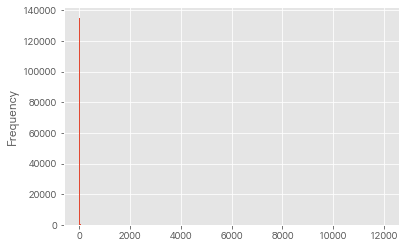

In [12]:
key_gas['C2H2'].plot(kind = 'hist', bins = 500)

In [13]:
np.percentile(key_gas.loc[:, 'C2H2'].values, 90, interpolation = 'nearest')

0.0

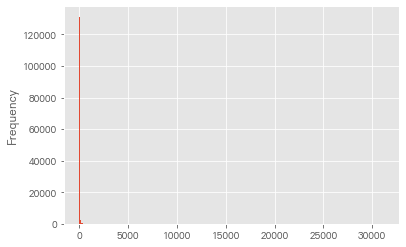

In [14]:
key_gas.loc[:, 'C2H4'].plot(kind = 'hist', bins = 500)

In [15]:
np.percentile(key_gas.loc[:, 'C2H4'].values, 90, interpolation = 'nearest')

26.0

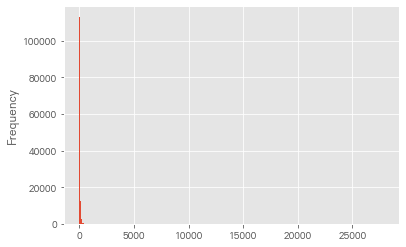

In [16]:
key_gas.loc[:, 'CH4'].plot(kind = 'hist', bins = 500)

In [17]:
np.percentile(key_gas.loc[:, 'CH4'].values, 90, interpolation = 'nearest')

91.0

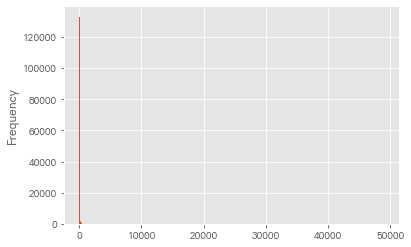

In [18]:
key_gas.loc[:, 'H2'].plot(kind = 'hist', bins = 500)

In [19]:
np.percentile(key_gas.loc[:, 'H2'].values, 90, interpolation = 'nearest')

21.0

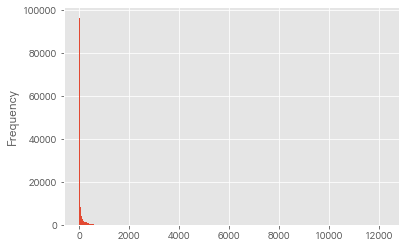

In [20]:
key_gas.loc[:, 'C2H6'].plot(kind = 'hist', bins = 500)

In [21]:
np.percentile(key_gas.loc[:, 'C2H6'].values, 90, interpolation = 'nearest')

171.0

In [22]:
PERCENTILE = 90

In [23]:
C2H2_nor_lim = np.percentile(key_gas['C2H2'].values, PERCENTILE, 
                                 interpolation = 'nearest')
C2H4_nor_lim = np.percentile(key_gas['C2H4'].values,  PERCENTILE,
                                 interpolation = 'nearest')
CH4_nor_lim = np.percentile(key_gas['CH4'].values,  PERCENTILE,
                                 interpolation = 'nearest')
H2_nor_lim = np.percentile(key_gas['H2'].values,  PERCENTILE,
                                 interpolation = 'nearest')
C2H6_nor_lim = np.percentile(key_gas['C2H6'].values,  PERCENTILE,
                                 interpolation = 'nearest')
print('Typical values:')
print('C2H2: {}'.format(C2H2_nor_lim))
print('C2H4: {}'.format(C2H4_nor_lim))
print('CH4: {}'.format(CH4_nor_lim))
print('H2: {}'.format(H2_nor_lim))
print('C2H6: {}'.format(C2H6_nor_lim))

Typical values:
C2H2: 0.0
C2H4: 26.0
CH4: 91.0
H2: 21.0
C2H6: 171.0


In [24]:
def val_gas(gas): #gas 측정 값이 가 계산이 가능할 정도인지 계산
    H2_lim = 5.0; CH_lim = 1.0;
    if gas['C2H2'] <=CH_lim*10:
        C2H2_val = CH_lim
    else:
        C2H2_val = gas['C2H2']
    
    if gas['C2H4'] <=CH_lim*10:
        C2H4_val = CH_lim
    else:
        C2H4_val = gas['C2H4']
        
    if gas['CH4'] <=CH_lim*10:
        CH4_val = CH_lim
    else:
        CH4_val = gas['CH4']
        
    if gas['C2H6'] <=CH_lim*10:
        C2H6_val = CH_lim
    else:
        C2H6_val = gas['C2H6']
        
    if gas['H2'] <= H2_lim*10:
        H2_val = H2_lim
    else:
        H2_val = gas['H2']
        
    return C2H2_val, C2H4_val, CH4_val, H2_val, C2H6_val

In [25]:
def IEC60599(gas, C2H2_nor_lim, C2H4_nor_lim, CH4_nor_lim, H2_nor_lim, C2H6_nor_lim):

    # key gas :'C2H2', 'C2H4', 'CH4', 'H2', 'C2H6'
    if (gas['C2H2']<= C2H2_nor_lim) and (gas['C2H4']<= C2H4_nor_lim) and \
       (gas['CH4']<= CH4_nor_lim) and (gas['H2']<= H2_nor_lim) and \
       (gas['C2H6']<= C2H6_nor_lim): #C2H2_nor_lim=0 이므로 등호포함
        return 'Normal'
    
    else:
        C2H2, C2H4, CH4, H2, C2H6 = val_gas(gas)
        r1 = C2H2/C2H4; r2 = CH4/H2; r3 = C2H4/C2H6;
        
        if (r2 < 0.1) & (r3 < 0.2):
            return 'PD'
        
        elif (r1 > 1.0) & (0.1<= r2 <= 0.5) & (r3 > 1.0):
            return 'D1'
        
        elif (0.6 <= r1 <= 2.5) & (0.1<= r2 <= 1.0) & (r3 > 2.0):
            return 'D2'
        
        elif (r2 > 1.0) & (r3 < 1.0):
            return 'T1'
        
        elif (r1 < 0.1) & (r2 > 1.0) & (1.0 <= r3 <= 4.0):
            return 'T2'
        
        elif (r1 < 0.2) & (r2 > 1.0) & (r3 > 4.0):
            return 'T3'
        
        else:
            return 'None'

In [26]:
data['r(IEC)'] = data[['C2H2', 'C2H4', 'CH4', 'H2', 'C2H6']].apply(IEC60599, 
                        C2H2_nor_lim = C2H2_nor_lim, C2H4_nor_lim= C2H4_nor_lim, 
                        CH4_nor_lim= CH4_nor_lim, H2_nor_lim=H2_nor_lim, 
                        C2H6_nor_lim=C2H6_nor_lim, axis = 1)

In [27]:
data.head(2)

,office1,office2,H2,C2H2,C2H4,CH4,C2H6,C3H8,CO,CO2,TCG1,TCG2,TG,C2H2/C2H4,CH4/H2,C2H4/C2H6,gas_ratio_p,S/S,eq_type,eq_num,eq_phase,volt_by_name,sample_year,sample_month,age(year),age(month),r(IEC)
0,제주본부,제주전력지사,0.0,0.0,0.0,7.0,0.0,0.0,23.0,84.0,7.0,7.0,114.0,1.0,1.4,1.0,1,신서귀S/S,M.Tr,#1,A,154,1998,6,0,5,Normal
1,제주본부,제주전력지사,10.0,0.0,0.0,1.0,0.0,0.0,87.0,1738.0,11.0,11.0,1836.0,1.0,0.1,1.0,1,신서귀S/S,M.Tr,#1,A,154,1998,11,0,10,Normal


In [28]:
data['r(IEC)'].value_counts()

Normal    101743
T1         17868
None       10341
T3          3052
T2          2471
PD           270
D1           148
D2            48
Name: r(IEC), dtype: int64

### 3.2 IEC Duval기준
- 코드 작성 시 하기 논문을 참고하였음  
- https://www.semanticscholar.org/paper/Implementation-of-Duval-Triangle-Technique-for-DGA-Singh-Joshi/d5b21a6defbcb6af5cb150c8ca7968312ed8c3b5/figure/5

<img src = 'pic/2.12.11.jpg' width = 400>

<img src = 'pic/2.12.12.jpg' width = 400>

<img src = 'pic/2.12.13.jpg' width = 500>

- 참고자료 : https://www.semanticscholar.org/paper/Implementation-of-Duval-Triangle-Technique-for-DGA-Singh-Joshi/d5b21a6defbcb6af5cb150c8ca7968312ed8c3b5/figure/5

In [29]:
def IECduval(gas, C2H2_nor_lim, C2H4_nor_lim, CH4_nor_lim, H2_nor_lim, C2H6_nor_lim):

    if (gas['CH4']>120) or (gas['C2H4']>50) or (gas['C2H2']>1):
        return 'None'
    # key gas :'C2H2', 'C2H4', 'CH4', 'H2', 'C2H6'
    elif (gas['C2H2']<= C2H2_nor_lim) and (gas['C2H4']<= C2H4_nor_lim) and \
       (gas['CH4']<= CH4_nor_lim) and (gas['H2']<= H2_nor_lim) and \
       (gas['C2H6']<= C2H6_nor_lim): #C2H2_nor_lim=0 이므로 등호포함
        return 'Normal'
    
    else:
        C2H2, C2H4, CH4, _, _ = val_gas(gas)
        total = (C2H2 + C2H4 + CH4)
        p1 = (C2H2/total)*100.0; p2 = (C2H4/total)*100.0; p3 = (CH4/total)*100.0;
        
        if p1 >= 98:
            return 'PD'
        
        elif p3 < 4:
            if 20 <= p2 <= 50:
                return 'T2'
            elif p2<20:
                return 'T1'
            else:
                return 'T'
        
        elif (p3 < 13) & (p2 < 23):
            return 'D1'
        
        elif p3 < 15 :
            if p2 >= 50:
                return 'T3'
            else:
                return 'T'
        
        elif (29 <= p3 <= 77) & (23 <= p2 <= 40):
            return 'D2'
        
        else:
            return 'T'

In [30]:
data['r(IECduval)'] = data[['C2H2', 'C2H4', 'CH4', 'H2', 'C2H6']].apply(IECduval, 
                        C2H2_nor_lim = C2H2_nor_lim, C2H4_nor_lim= C2H4_nor_lim, 
                        CH4_nor_lim= CH4_nor_lim, H2_nor_lim=H2_nor_lim, 
                        C2H6_nor_lim=C2H6_nor_lim, axis = 1)

In [31]:
data.head(2)

,office1,office2,H2,C2H2,C2H4,CH4,C2H6,C3H8,CO,CO2,TCG1,TCG2,TG,C2H2/C2H4,CH4/H2,C2H4/C2H6,gas_ratio_p,S/S,eq_type,eq_num,eq_phase,volt_by_name,sample_year,sample_month,age(year),age(month),r(IEC),r(IECduval)
0,제주본부,제주전력지사,0.0,0.0,0.0,7.0,0.0,0.0,23.0,84.0,7.0,7.0,114.0,1.0,1.4,1.0,1,신서귀S/S,M.Tr,#1,A,154,1998,6,0,5,Normal,Normal
1,제주본부,제주전력지사,10.0,0.0,0.0,1.0,0.0,0.0,87.0,1738.0,11.0,11.0,1836.0,1.0,0.1,1.0,1,신서귀S/S,M.Tr,#1,A,154,1998,11,0,10,Normal,Normal


In [32]:
data['r(IECduval)'].value_counts()

Normal    101743
None       15037
T          12443
D2          6336
T3           382
Name: r(IECduval), dtype: int64